{'month': '2019-03', 'type': 'moneySales', 'format': 'graph', 'prediction': 'True'}


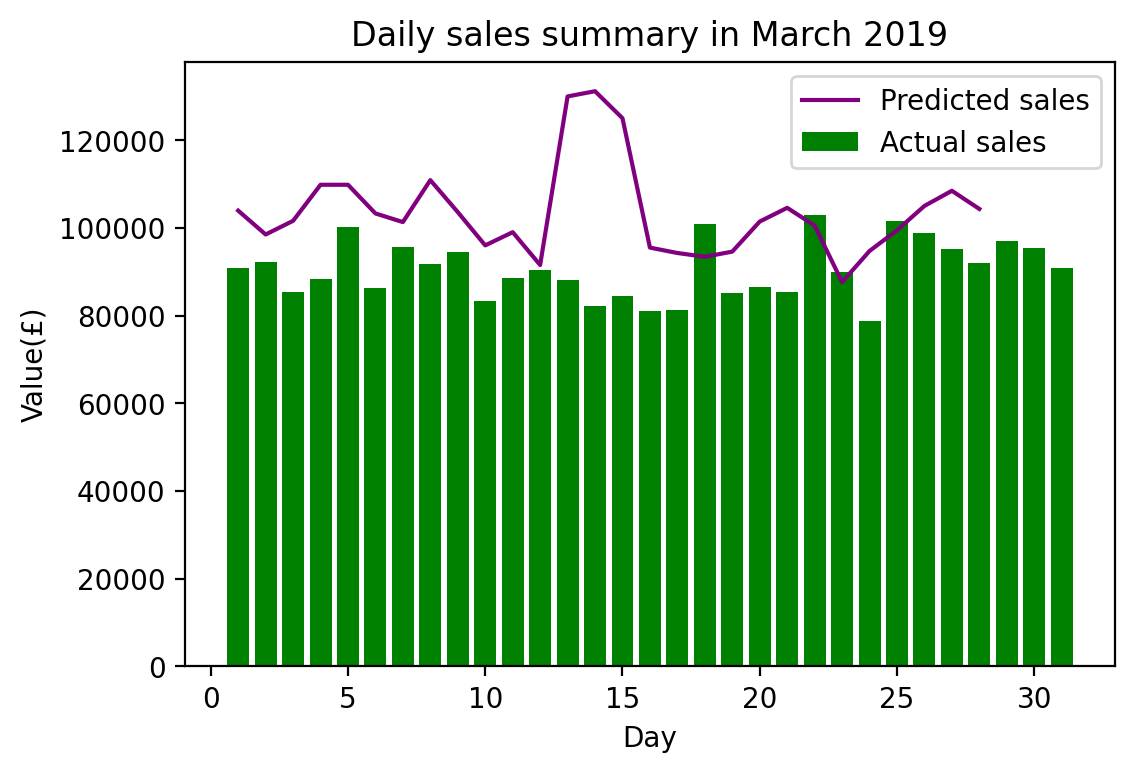

In [37]:
from ast import arg
from time import time
import mysql.connector as dbCon
import pandas as pd
import numpy as np
import os
import glob
import pandas as pd
import datetime
import math
import json
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import sys

conn = dbCon.connect(host="localhost", user="root", password="cqX*5gk6^hvNFPvE", database="dsp")
argDict = {'month': '2019-03', 'type': 'moneySales', 'format':'graph', 'prediction': 'True'}
print(argDict)
if bool(argDict['month']): #month
    date = datetime.datetime.strptime(argDict['month'], '%Y-%m')
    month = date.month
    year = date.year
    monthNames = ["January",
                "Febuary",
                "March",
                "April",
                "May",
                "June",
                "July",
                "August",
                "September",
                "October",
                "November",
                "December"]

    if argDict['type'] == 'moneySales':
        sql = "SELECT DayT, Value FROM money_sales WHERE MONTH(DayT) = %s AND YEAR(DayT) = %s"
        salesCursor = conn.cursor()
        param = (month, year)
        salesCursor.execute(sql, param)
        salesResult = salesCursor.fetchall()
        salesCursor.close()
        moneyDF = pd.DataFrame(salesResult, columns=['Date', 'Value'])
        moneyDF['Day'] = pd.to_datetime(moneyDF['Date']).dt.day
        dailyDF = moneyDF.groupby('Day')['Value'].sum().reset_index()
        dailyPreviousMoneyDF = None
        dailyPredictionMoneyDF = None

        if 'previous' in argDict:
            previousCursor = conn.cursor()
            paramPrevious = (month - 1, year)
            previousCursor.execute(sql, paramPrevious)
            previousResult = previousCursor.fetchall()
            previousCursor.close()
            previousMoneyDF = pd.DataFrame(data=previousResult, columns=['Date', 'Value'])
            previousMoneyDF['Day'] = pd.to_datetime(previousMoneyDF['Date']).dt.day
            dailyPreviousMoneyDF = previousMoneyDF.groupby('Day')['Value'].sum().reset_index()

        if 'prediction' in argDict:
            predictionCursor = conn.cursor()
            predictionSql = 'SELECT DayT, Predicted_Value from money_pred WHERE MONTH(DayT) = %s AND YEAR(DayT) = %s'
            predictionCursor.execute(predictionSql, param)
            predictionResult = predictionCursor.fetchall()
            predictionCursor.close()
            predictionMoneyDF = pd.DataFrame(data=predictionResult, columns=['Date', 'PredValue'])
            predictionMoneyDF['Day'] = pd.to_datetime(predictionMoneyDF['Date']).dt.day
            dailyPredictionMoneyDF = predictionMoneyDF.groupby('Day')['PredValue'].sum().reset_index()

        if argDict['format'] == 'graph':
            plt.figure(dpi=200)
            plt.bar(x = dailyDF['Day'], height = dailyDF['Value'], color = 'green', label='Actual sales')
            plt.title('Daily sales summary in ' + monthNames[month - 1] + ' ' + str(year))
            plt.xlabel('Day')
            plt.ylabel('Value(£)')
            
            if dailyPredictionMoneyDF is not None:
                plt.plot(dailyPredictionMoneyDF['Day'], dailyPredictionMoneyDF['PredValue'], c = 'purple', label='Predicted sales')

            if dailyPreviousMoneyDF is not None:
                plt.plot(dailyPreviousMoneyDF['Day'], dailyPreviousMoneyDF['Value'], c = 'orange', label="Last month's sales")
            
            
            plt.legend()
            plt.savefig('python/graph.jpg', bbox_inches = 'tight')

        #else: #table


 
conn.close()

In [5]:
text = '2019-01-04'
text = text[:6] + str(int(text[6]) + 1) + text[7:]
text

'2019-02-04'